# MiniEP3 - Aproximação de Integrais usando Médias e Amostragem Uniforme, com a biblioteca *pthreads*

## Entrega do miniEP3

Preencha o nome dos 5 membros do seu grupo na tabela abaixo:

| Nome | NUSP |
|------|------|
| Membro1 | 12345789 |
| Membro2 | 12345789 |
| Membro3 | 12345789 |
| Membro4 | 12345789 |
| Membro5 | 12345789 |

**Apenas um dos membros** deverá entregar um **arquivo .tar**, até o dia **29 de Abril**, com:

1. **Este arquivo** `.ipynb`, com as soluções do miniEP3 **feitas pelo grupo**
    
    - Os gráficos e análises devem poder ser produzidos
    
    
2. O **código C escrito** (arquivo `monte_carlo.c`)

    - Deve compilar e executar **sem erros**
    
    
    
3. Os arquivos `Makefile`, e `Project.toml`
4. Um **arquivo .csv** com os resultados das medições feitas neste miniEP

    - Entregue os dados de cada repetição, sem processamento (não calcule a média e CI)

## Configuração do Ambiente

Como no miniEP1&2, a primeira tarefa é instalar e configurar o ambiente.

### Compilador C

Neste miniEP também vamos usar a linguagem C e a biblioteca *pthreads*. Vocês vão precisar de acesso a um sistema Linux com o compilador GCC e a biblioteca *pthreads*. Caso não consiga instalar o GCC ou tenha dificuldades para acessar um sistema Linux, entre em contato pelo fórum do *Edisciplinas*.

### Julia, Jupyter, IJulia

Pule essa etapa se já configurou o ambiente Julia no miniEP1&2.
Para fazer o miniEP, vocês vão precisar:

- [Instalar o Jupyter Notebook](https://jupyter.readthedocs.io/en/latest/install.html)
- Instalar Julia 1.3:
    - [Baixando o binário](https://julialang.org/downloads/)
    - **ou** [usando seu gerenciador de pacotes](https://julialang.org/downloads/platform/)
- Instalar o pacote *IJulia*:
    - Inicie o interpretador Julia
    - Digite `] add IJulia` e pressione `<ENTER>`
    
Depois disso, vocês vão conseguir iniciar o arquivo `.ipynb` do miniEP.

### Pacotes Julia para o miniEP

Os pacotes necessários para o miniEP estão listados no arquivo `Project.toml`, mas vocês podem instalar e atualizar os pacotes rodando a célula abaixo:

In [3]:
] up

   Updating registry at `~/.julia/registries/General`


ErrorException: could not load library "libgit2"
/usr/bin/../lib64/libmbedx509.so.0: undefined symbol: mbedtls_mutex_unlock

Verifique o status dos pacotes, e se há algum problema, com o comando:

In [4]:
] st

Status `~/Documentos/Paralela/2020/miniEP3/Project.toml`
  (empty environment)


## Integração por Método de Monte Carlo

O objetivo deste miniEP é promover o estudo de programação paralela usando a biblioteca *pthreads*. Vamos utilizar uma versão sequencial em C do código em Julia do miniEP1&2. A tarefa deste miniEP será completar a implementação em C, escrever um programa paralelo usando a biblioteca *pthreads*, e analisar o desempenho do programa escrito com diferentes números de threads.

Lembrando o que vimos no miniEP1&2, a intuição por trás do método de Monte Carlo é que a integral de uma função $f$ pode ser estimada pela média do valor de $f$ num conjunto suficientemente grande de pontos obtidos a partir de uma distribuição uniforme. Mais formalmente, para um conjunto de pontos $x_1,\dots,x_N$ uniformemente amostrados num intervalo $[a,b]$, a integral de $f$ no intervalo $[a,b]$ pode ser aproximada por:

$$
\int_{a}^{b} f(x)dx \approx \mathbb{E}\left[\left(b - a\right)\dfrac{1}{N}\sum\limits_{i = 1}^{N}{f(x_i)}\right] 
$$

Para uma representação gráfica da intuição, e para a prova dessa aproximação, veja [esta página](https://www.scratchapixel.com/lessons/mathematics-physics-for-computer-graphics/monte-carlo-methods-in-practice/monte-carlo-integration).

A Integração por Método de Monte Carlo é um problema [embaraçosamente paralelo](https://en.wikipedia.org/wiki/Embarrassingly_parallel), isto é, podemos executar todas as iterações envolvidas **em paralelo**, sem nos preocupar com conflitos de acesso à memória. Apesar disso, vamos ver neste miniEP que não basta apenas aumentar a quantidade de recursos computacionais para ganhar desempenho.

### Função Alvo

Vamos estimar a integral da seguinte função:

$$
f_1(x) = \dfrac{2}{\sqrt{1 - x ^ 2}}
$$

A integral da função $f_1$, é [dada por](https://en.wikipedia.org/wiki/List_of_definite_integrals#Definite_integrals_involving_rational_or_irrational_expressions):

$$
\int_{0}^{1}{f_1(x)dx} = \int_{0}^{1}{\dfrac{2}{\sqrt{1 - x ^ 2}}dx} = \pi
$$

## Exercício 1: Implementação Sequencial em C

Lembre-se do código em Julia:

In [5]:
using Distributions

function monte_carlo_integrate(f, interval, samples = 100)
    xs = rand(Uniform(interval[1], interval[2]), samples)
    
    # Using for loops:
    # accumulator = 0
    #
    # for x in xs
    #     accumulator += f(x)
    # end
    #
    # return accumulator / samples
    
    # Using vectorized function application:
    return sum(f.(xs)) / samples
end

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1260


monte_carlo_integrate (generic function with 2 methods)

O primeiro exercício consiste em completar a implementação sequencial em C, fornecida no arquivo `monte_carlo.c`. Baseiem-se na versão Julia, e usem seus editores de código preferidos para modificar e escrever código em C. Se vocês ainda não têm preferência de editor de código, procurem experimentar editores como o Emacs e o Vim. São programas antigos e com uma curva de aprendizado um pouco íngreme, mas são muito poderosos e os esforços se pagam com juros. Esta pode ser uma chance de aprender a usá-los.

Vocês devem escrever a função de assinatura:

```C
long double monte_carlo_integrate(long double (*f)(long double), long double *samples, int size)
```

Na assinatura acima, o parâmetro `f` é um ponteiro para uma função que recebe um `long double` e devolve um `long double`, `samples` é um ponteiro para um vetor de `long double` onde vamos guardar os valores de `f` que queremos avaliar, e `size` é o tamanho de `samples`.

A primeira parte do exercício é ler e compreender o funcionamento do código em C fornecido no enunciado. É um exercício interessante para ver como uma linguagem de alto nível, como Julia, abstrai camadas conceituais e facilita a prototipagem de código complexo ao custo de esconder detalhes de implementação.

### Exercício 1a)

Vocês podem compilar e executar o programa `monte_carlo.c` através deste notebook acessando o *modo shell* do interpretador Julia com a tecla `;`:

In [6]:
; make debug

gcc monte_carlo.c -o monte_carlo -Wall -lpthread -lm -DDEBUG=1


monte_carlo.c: In function ‘main’:
monte_carlo.c:231:13: warning: variable ‘rc’ set but not used [-Wunused-but-set-variable]
  231 |         int rc;
      |             ^~


Depois, podemos rodar o programa compilado com:

In [7]:
; ./monte_carlo

usage: ./monte_carlo SAMPLES FUNCTION_ID N_THREADS


Seguindo as instruções de uso, temos:

In [8]:
; ./monte_carlo 10000000 0 1

Running on: [debug mode]
Samples: [10000000]
Function id: [0]
Threads: [1]
Array size on memory: [0.16GB]
Running sequential version
3.1390072125499791, [0.390193, clock], [0.392327, clock_gettime], [0.392326, gettimeofday]


Como compilamos no modo *debug*, veremos muitas mensagens extras, que coloquei no programa pra ajudar na implementação. Para compilar no modo normal, use o comando `make` sem argumentos. Note que o programa ainda não faz nada além de alocar memória, e que isso já leva algum tempo.

Note que escolhi deixar a alocação de memória e o cálculo das amostra a avaliar fora da função `monte_carlo_integrate` na versão C. A geração das amostras aleatórias foi feita com a função `rand()` e com uma função que mapeia um intervalo a outro.


Descreva abaixo como o tempo de execução é calculado e impresso pelo programa `monte_carlo`. Por que vocês acham que eu escolhi colocar as medições de tempo onde coloquei?

### Exercício 1b)

Agora, a sua tarefa é implementar a função `monte_carlo_integrate`.

Quando terminar, rode as células abaixo. A saída deve conter a estimativa para o valor de $\pi$ e o tempo de execução, produzidos pelo programa `monte_carlo`. Escolha um número de amostras adequado à quantidade de memória disponível em seu computador.

Lembre-se de **entregar também o arquivo .c** com suas modificações.

In [9]:
; make debug

gcc monte_carlo.c -o monte_carlo -Wall -lpthread -lm -DDEBUG=1


monte_carlo.c: In function ‘main’:
monte_carlo.c:231:13: warning: variable ‘rc’ set but not used [-Wunused-but-set-variable]
  231 |         int rc;
      |             ^~


In [10]:
; ./monte_carlo 100000000 0 1

Running on: [debug mode]
Samples: [100000000]
Function id: [0]
Threads: [1]
Array size on memory: [1.60GB]
Running sequential version
3.1410891974325881, [3.758691, clock], [3.768210, clock_gettime], [3.768209, gettimeofday]


## Exercício 2: Implementação Paralela com *pthreads*

Este exercício é mais complexo. Vocês devem escrever a função de assinatura:

```C
void *monte_carlo_integrate_thread(void *args)
```

Na assinatura acima, o parâmetro `args` é um ponteiro para uma estrutura de dados contendo dados para cada thread. Para implementar essa estrutura de dados, vocês devem decidir quais informações cada thread deve receber. Algumas ideias:

- Um ponteiro para a função a ser avaliada
- Um ponteiro para o vetor de amostras gerado
- Um inteiro com o id da thread

De acordo com a sua estratégia de implementação paralela, vocês vão precisar incluir informações diferentes. Algo de importante está faltando na lista acima. Como as threads poderiam armazenar seus resultados?

Precisamos escolher uma dentre as várias formas de implementar esse algoritmo paralelo. Pensei em algumas possibilidades:

1. Método "Criando threads dinamicamente":
  - Lançar $n$ threads, cada uma com $1$ (ou $m$?) unidades de trabalho a fazer
  - Usar variáveis de condição ou joins para sinalizar fim de trabalho
  - Lançar novas threads conforme threads terminarem
  - Usar join para finalizar
2. Método "Divisão Dinâmica do Trabalho":
  - Lançar $n$ threads, cada uma com $1$ (ou $m$?) unidades de trabalho a fazer
  - Cada thread busca por trabalho disponível a fazer quando acabar o trabalho dado
  - Usar join para finalizar
3. Método "Divisão Estática do Trabalho":
  - Lançar $n$ threads, cada uma com $1/n$ unidades de trabalho a fazer
  - Usar join para finalizar
  
Usando seus conhecimentos sobre *pthreads* e sobre a execução de programas em geral, responda e explique:

1. Qual desses métodos é o mais difícil de implementar? E o mais fácil?
2. Qual método atingiria o menor tempo de execução?

Escolha um desses, ou um quarto método que preferir, para fazer a implementação paralela do miniEP3. Vocês vão precisar implementar toda a estrutura de suporte à execução das threads.

Quando terminar, rode as células abaixo. A saída deve conter a estimativa para o valor de $\pi$ e o tempo de execução, produzidos pelo programa `monte_carlo`. Escolha um número de amostras e de threads adequado à quantidade de memória e aos núcleos de processamento disponíveis em seu computador.

Lembre-se de **entregar também o arquivo .c** com suas modificações.

In [11]:
; make debug

gcc monte_carlo.c -o monte_carlo -Wall -lpthread -lm -DDEBUG=1


monte_carlo.c: In function ‘main’:
monte_carlo.c:231:13: warning: variable ‘rc’ set but not used [-Wunused-but-set-variable]
  231 |         int rc;
      |             ^~


In [12]:
; ./monte_carlo 100000000 0 32

Running on: [debug mode]
Samples: [100000000]
Function id: [0]
Threads: [32]
Array size on memory: [1.60GB]
Running parallel version
3.1411957960445114, [4.572153, clock], [3.277099, clock_gettime], [3.277099, gettimeofday]


## Exercício 3: Análise de Desempenho

Agora, vamos medir o desempenho do programa que vocês implementaram neste trabalho. Vamos usar funções em Julia, adaptadas do miniEP1&2, e gerar gráficos do tempo de execução e da estimativa da integral para diferentes números de threads.

### Funções Úteis

A função abaixo recebe parâmetros `size`, com tamanho da amostra, `f`, com a id da função a estimar, e `threads`, com o número de threads do programa paralelo. A função executa o programa `monte_carlo` com os parâmetros dados e devolve um `DataFrame` com os resultados.

In [13]:
using DataFrames, Query, StatsPlots

function measure_monte_carlo(size, f, threads)
    results = parse.(Float64,
        split(chomp(read(`./monte_carlo $size $f $threads`, String)), ", "))
        
    return DataFrame(size = size,
        f = f,
        threads = threads,
        estimate = results[1],
        duration = results[2])
end

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1260


measure_monte_carlo (generic function with 1 method)

A função `run_experiments` recebe os mesmos parâmetros `size`, `f`, e `threads`, e um parâmetro adicional `repetitions`, com o número de repetições de cada experimento com um dado número de `threads`. A função devolve um `DataFrame` com todos os experimentos.

In [14]:
function run_experiments(size, f, threads, repetitions)
    run(`make`)
    
    results = DataFrame(size = Int[],
        f = Int[],
        threads = Int[],
        estimate = Float64[],
        duration = Float64[])  
    
    for t in threads
        for r in 1:repetitions
            append!(results,
                measure_monte_carlo(size, f, t))    
        end
    end
    
    return results
end

run_experiments (generic function with 1 method)

A função `parse_results` recebe um `DataFrame` de resultados, produzido pela função `run_experiments`, e um parâmetro `target_integral`, com o valor da integral a estimar. A função devolve um `DataFrame` com a média e o intervalo de confiança da média a 95% das estimativas e dos tempos de execução, agrupados por número de threads.

In [15]:
function parse_results(results, target_integral)
    parsed_results = results |>
                    @groupby(_.threads) |>
                    @map({threads = key(_),
                          mean_estimate = mean(_.estimate),
                          ci_estimate = 1.96 * std(_.estimate),
                          mean_duration = mean(_.duration),
                          ci_duration = 1.96 * std(_.duration),
                          target = target_integral}) |>
                    DataFrame
    
    return parsed_results
end

parse_results (generic function with 1 method)

### Exercício 3a)

Realize os experimentos em sua máquina rodando a célula abaixo. Ajuste os valores para a sua máquina. **Não faça menos de 5 repetições**.

In [16]:
size = 20000000
f = 0
threads = 1:32
repetitions = 5

results = run_experiments(size, f, threads, repetitions)
parsed_results = parse_results(results, pi)

gcc monte_carlo.c -o monte_carlo -Wall -lpthread -lm


monte_carlo.c: In function ‘main’:
monte_carlo.c:231:13: warning: variable ‘rc’ set but not used [-Wunused-but-set-variable]
  231 |         int rc;
      |             ^~


,threads,mean_estimate,ci_estimate,mean_duration,ci_duration,target
,Int64,Float64,Float64,Float64,Float64,Irration…
1,1,3.14271,0.00327585,0.75316,0.0151952,π
2,2,3.14145,0.00315976,0.655686,0.00428949,π
3,3,3.14041,0.00157052,0.667742,0.0203894,π
4,4,3.14215,0.00211303,0.647521,0.00140168,π
5,5,3.14261,0.00138157,0.65671,0.00840314,π
6,6,3.14065,0.00123129,0.662048,0.0293687,π
7,7,3.14275,0.00118142,0.651382,0.00269699,π
8,8,3.14158,0.00141489,0.64917,0.00265921,π
9,9,3.14163,0.00105402,0.653335,0.0136488,π


Agora, escreva uma função **em Julia** chamada `save_csv_results`, que recebe um `DataFrame` e um nome de arquivo, e escreve o `DataFrame` em disco, no formato `.csv`, com o nome passado no argumento.

Utilize a biblioteca [CSV](https://juliadata.github.io/CSV.jl/stable/), já instalada no ambiente deste notebook.

In [17]:
using CSV
function save_csv_results(parsed_results, name)
    CSV.write(string(name, ".csv"), parsed_results)
end

save_csv_results (generic function with 1 method)

Escreva uma função **em Julia** chamada `read_csv_results`, que recebe um nome de arquivo e lê o arquivo correspondente, devolvendo um `DataFrame`.

In [18]:
using CSV
function read_csv_results(filename)
    return CSV.read(filename)
end

read_csv_results (generic function with 1 method)

Salve o DataFrame `results` em disco. **Vocês devem entregar o .csv também**.

### Exercício 3b)

Como vocês já se familiarizaram um pouco com funções para geração de gráficos no miniEP1&2, explique o que faz a função `plot_results` abaixo. Ela é uma generalização das funções usadas no miniEP anterior. Para ajudar, você pode modificar e usar as chamadas de função no **Exercício 3c)**.

In [19]:
function plot_results(x, y, target_label, series_label; hline = [], yerror = [])      
    if yerror != []
        p = scatter(x,        
            y,
            yerror = yerror,
            alpha = 0.6,
            labels = series_label,
            legend = :topleft)
    else
        p = scatter(x,        
            y,
            alpha = 0.6,
            labels = series_label,
            legend = :topleft)
    end
    
    if hline != []
        plot!(x,        
            hline,
            labels = target_label,                 
            line = :dash,        
            width = 2.0)
    end
    
    return p
end


plot_results (generic function with 1 method)

### Exercício 3c)

1. Rode as células na seção abaixo e gere os gráficos. **Entregue o notebook com os gráficos gerados**.
2. Descreva o comportamento do tempo de execução conforme aumentamos o número de threads, em termos da média e do intervalo de confiança. Nos próximos EPs, vamos aprender a fazer uma *regressão linear* que explique os dados observados usando *coeficientes*.
3. Por que você acha que o tempo de execução aumenta conforme aumentamos as threads? Era isso que você esperava?

Responda na célula abaixo:

**Respostas:**

**1)** *Gráficos abaixo*

**2)** Percebemos que até 5 threads o tempo de execução médio é mais alto que o normal e o intervalo de conficança tem alta amplitude. Porém a partir disso o programa passa a rodar mais rapido e com intervalo de menor aplitude, atingindo dados consistentes até certo ponto, onde volta a ficar mais lento e menos confiavel.

**3)** Acreditamos que a razão dessa alta no tempo de execução se deve ao limite de Core´s, capacidade de processamento do computador e de memória. Isso já que até certo numero de threads, a divisão de tarefas entre as threads se mostra efetiva e realmente torna o programa mais rápido, porém, ao atingir certa quantidade de threads, o escalonamento extenso e a grande quantidade de threads em relação aos Core´s acabam gerando bottlenecks e travamentos devido à competição de recursos, que geram esse aumento no tempo de execução.

#### Gerando Gráficos

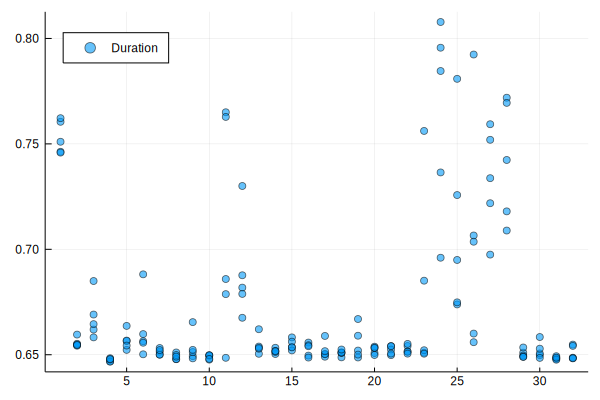

In [20]:
plot_results(results.threads,
    results.duration,    
    "pi",
    "Duration")

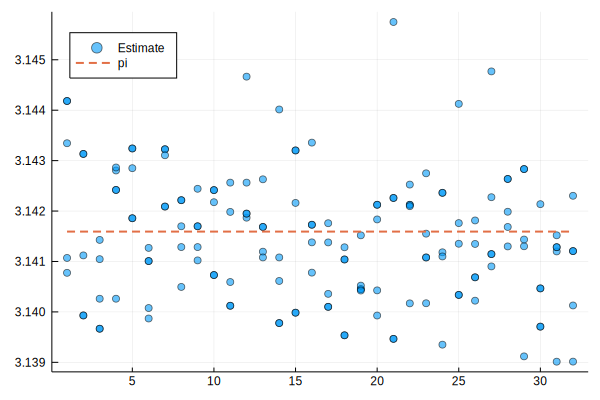

In [21]:
plot_results(results.threads,
    results.estimate,    
    "pi",
    "Estimate",
    hline = [pi for i in 1:nrow(results)])

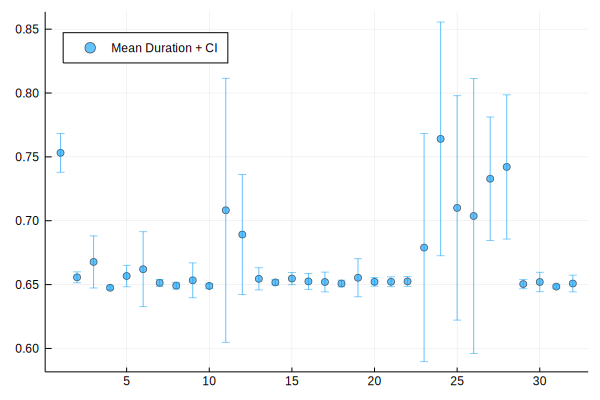

In [22]:
plot_results(parsed_results.threads,
    parsed_results.mean_duration,
    "pi",
    "Mean Duration + CI",
    yerror = parsed_results.ci_duration)

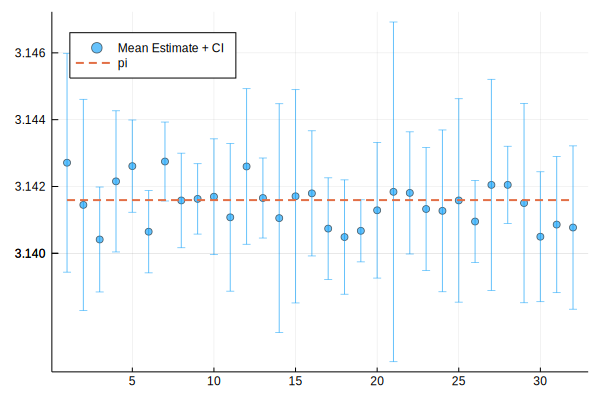

In [23]:
plot_results(parsed_results.threads,
    parsed_results.mean_estimate,
    "pi",
    "Mean Estimate + CI",
    hline = [pi for i in 1:nrow(parsed_results)],
    yerror = parsed_results.ci_estimate)